In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.linalg as lin
from scipy.integrate import trapz
from scipy.optimize import minimize
import logging
import sys
sys.path.append("/home/mcetina/git/euriqa-artiq/gate_solutions")
#from trap_potentials import HOAPotential
#from mode_solver import TrapModel
from gate_solver import AM_XXGate, AMLine_XXGate
logging.basicConfig(level=logging.INFO)
np.set_printoptions(precision=5, suppress=True)

In [2]:
# If you are on the UMD EURIQA team, you can save these to files so that the AWG can use 
from euriqabackend.devices.keysight_awg.common_types import XXGateParams, XXModulationType, gen_all_IonPairs
from euriqabackend.devices.keysight_awg.gate_parameters import GateSolution
import pathlib
import itertools
import pandas as pd

In [3]:
#Initialize the gate data structure
n_ions = 23
data_structure = GateSolution(num_ions=n_ions)

In [29]:
gate_time = 300e-6
n_seg = 16
dw = np.array([-900, 900])*2*math.pi  # Note: gates calculations always use angular units
MHz = 1e6
w_k = [x + 1500 for x in np.array(
        [
            3.065 * MHz,
            3.062 * MHz,
            3.05355 * MHz,
            3.044 * MHz + 100,
            3.033 * MHz - 100,
            3.020 * MHz + 300,
            3.006 * MHz + 500,
            2.992 * MHz - 0,
            2.976 * MHz + 300,
            2.960 * MHz + 0,
            2.943 * MHz + 200,
            2.9255 * MHz + 500, #10
            2.907 * MHz + 1400, #11
            2.8906 * MHz + 100, #12
            2.8725 * MHz + 400, #13
            2.855 * MHz + 350, #14
            2.838 * MHz + 250, #15
            2.8215 * MHz + 250, #16
            2.806 * MHz + 250, #17
            2.792 * MHz,
            2.7802 * MHz + 350,
            2.767 * MHz,
            2.763 * MHz
        ]
    )]    
w_k = 2*np.pi*np.array(w_k)
w_k = np.flip(w_k)

In [30]:
b_jk = np.array([[-0.000131698, -0.000197249, -0.000379504, -0.000763418, \
-0.00146858, -0.00274552, 0.00496414, 0.00867335, 
  0.0146339, -0.0238316, -0.0374406, -0.0567089, -0.0827382, 0.116148,
   0.156642, 0.202541, 
  0.250384, -0.294772, -0.32566, -0.35976, -0.293062, 0.47466, 
  0.460807], [0.00204711, 0.00301807, 0.00544096, 0.010246, 0.0181312,
   0.0308008, -0.0499795, -0.0773899, -0.114194, 0.160302, 0.213575, 
  0.269178, 0.319392, -0.354251, -0.36323, -0.337924, -0.275217, 
  0.18006, 0.0666588, -0.0499059, -0.0923326, 0.346692, 
  0.34033], [-0.0127886, -0.0185372, -0.0310006, -0.0540733, \
-0.0867253, -0.131225, 0.186074, 0.246352, 
  0.302665, -0.341712, -0.348612, -0.311106, -0.224798, 
  0.0976598, -0.0485041, -0.181538, -0.267676, 0.283489, 0.22514, 
  0.119915, 0.0303121, 0.260825, 0.259711], [0.046072, 0.0654012, 
  0.0995821, 0.157465, 0.221696, 
  0.285588, -0.331253, -0.33855, -0.290851, 0.183819, 
  0.0324952, -0.127644, -0.248876, 0.288067, 0.226408, 
  0.0824902, -0.0901032, 0.223285, 0.263506, 0.21443, 0.111437, 
  0.197596, 
  0.200652], [-0.111437, -0.153937, -0.206757, -0.284822, -0.329293, \
-0.322167, 0.243073, 0.0964754, -0.0820556, 0.23181, 0.290031, 
  0.224194, 0.0565239, 0.137094, 0.260155, 0.247047, 0.103589, 
  0.0917803, 0.230278, 0.259892, 0.165858, 0.149289, 
  0.155951], [0.197601, 0.262906, 0.29443, 0.324532, 0.253802, 
  0.0973483, 0.100712, 0.25614, 0.286903, -0.165892, 0.0481299, 
  0.231787, 0.269008, -0.131336, 0.0928085, 0.251231, 
  0.233992, -0.0552488, 0.154267, 0.270786, 0.201783, 0.11174, 
  0.121784], [-0.273514, -0.344465, -0.286552, -0.19201, 0.0161577, 
  0.221018, -0.300219, -0.189903, 
  0.0481459, -0.249065, -0.259986, -0.0669815, 
  0.17798, -0.271939, -0.133502, 0.119002, 0.265556, -0.17987, 
  0.0560091, 0.25653, 0.224596, 0.0822835, 0.0957837], [0.311915, 
  0.360434, 0.159757, -0.0609592, -0.27192, -0.286962, 
  0.0752692, -0.196412, -0.288371, 
  0.111026, -0.169791, -0.277942, -0.10287, -0.176038, -0.266791, \
-0.0733042, 0.197323, -0.256692, -0.0482019, 0.223905, 0.238215, 
  0.0589997, 0.0763419], [-0.309488, -0.309034, 0.0361862, 0.280332, 
  0.291235, 0.0221487, 0.261658, 0.253369, -0.0396552, 0.278947, 
  0.181109, -0.134169, -0.277955, 0.0717588, -0.222433, -0.229921, 
  0.057645, -0.272107, -0.144794, 0.178123, 0.245655, 0.0403692, 
  0.0623102], [0.284103, 0.216046, -0.224316, -0.340971, -0.0639186, 
  0.274389, -0.238486, 0.117242, 0.297248, -0.0519091, 0.260636, 
  0.186458, -0.160017, 
  0.262672, -0.0288579, -0.274059, -0.104073, -0.224982, -0.222554, 
  0.123348, 0.249248, 0.0250962, 0.0528589], [-0.258513, -0.10866, 
  0.350507, 0.224276, -0.21935, -0.282875, -0.110719, -0.301882, 
  0.0168746, -0.295054, -0.0640094, 0.269727, 0.131889, 0.23101, 
  0.187127, -0.182667, -0.231491, -0.126834, -0.27288, 0.0630012, 
  0.250699, 0.0120086, 0.0474148], [0.248268, 0, -0.393797, 0, 
  0.343309, 0, 0.317812, 0, -0.302686, 0, -0.292275, 0, 0.284925, 0, 
  0.280337, 0, -0.279689, 0, -0.290285, 0, 0.251064, 0, 
  0.0456379], [-0.258513, 0.10866, 0.350507, -0.224276, -0.21935, 
  0.282875, -0.110719, 0.301882, 0.0168746, 
  0.295054, -0.0640094, -0.269727, 0.131889, -0.23101, 0.187127, 
  0.182667, -0.231491, 0.126834, -0.27288, -0.0630012, 
  0.250699, -0.0120086, 0.0474148], [0.284103, -0.216046, -0.224316, 
  0.340971, -0.0639186, -0.274389, -0.238486, -0.117242, 0.297248, 
  0.0519091, 0.260636, -0.186458, -0.160017, -0.262672, -0.0288579, 
  0.274059, -0.104073, 0.224982, -0.222554, -0.123348, 
  0.249248, -0.0250962, 0.0528589], [-0.309488, 0.309034, 
  0.0361862, -0.280332, 0.291235, -0.0221487, 
  0.261658, -0.253369, -0.0396552, -0.278947, 0.181109, 
  0.134169, -0.277955, -0.0717588, -0.222433, 0.229921, 0.057645, 
  0.272107, -0.144794, -0.178123, 0.245655, -0.0403692, 
  0.0623102], [0.311915, -0.360434, 0.159757, 0.0609592, -0.27192, 
  0.286962, 0.0752692, 0.196412, -0.288371, -0.111026, -0.169791, 
  0.277942, -0.10287, 0.176038, -0.266791, 0.0733042, 0.197323, 
  0.256692, -0.0482019, -0.223905, 0.238215, -0.0589997, 
  0.0763419], [-0.273514, 0.344465, -0.286552, 0.19201, 
  0.0161577, -0.221018, -0.300219, 0.189903, 0.0481459, 
  0.249065, -0.259986, 0.0669815, 0.17798, 
  0.271939, -0.133502, -0.119002, 0.265556, 0.17987, 
  0.0560091, -0.25653, 0.224596, -0.0822835, 
  0.0957837], [0.197601, -0.262906, 0.29443, -0.324532, 
  0.253802, -0.0973483, 0.100712, -0.25614, 0.286903, 0.165892, 
  0.0481299, -0.231787, 0.269008, 0.131336, 0.0928085, -0.251231, 
  0.233992, 0.0552488, 0.154267, -0.270786, 0.201783, -0.11174, 
  0.121784], [-0.111437, 0.153937, -0.206757, 0.284822, -0.329293, 
  0.322167, 0.243073, -0.0964754, -0.0820556, -0.23181, 
  0.290031, -0.224194, 0.0565239, -0.137094, 0.260155, -0.247047, 
  0.103589, -0.0917803, 0.230278, -0.259892, 0.165858, -0.149289, 
  0.155951], [0.046072, -0.0654012, 0.0995821, -0.157465, 
  0.221696, -0.285588, -0.331253, 0.33855, -0.290851, -0.183819, 
  0.0324952, 0.127644, -0.248876, -0.288067, 
  0.226408, -0.0824902, -0.0901032, -0.223285, 0.263506, -0.21443, 
  0.111437, -0.197596, 0.200652], [-0.0127886, 0.0185372, -0.0310006, 
  0.0540733, -0.0867253, 0.131225, 0.186074, -0.246352, 0.302665, 
  0.341712, -0.348612, 0.311106, -0.224798, -0.0976598, -0.0485041, 
  0.181538, -0.267676, -0.283489, 0.22514, -0.119915, 
  0.0303121, -0.260825, 0.259711], [0.00204711, -0.00301807, 
  0.00544096, -0.010246, 0.0181312, -0.0308008, -0.0499795, 
  0.0773899, -0.114194, -0.160302, 0.213575, -0.269178, 0.319392, 
  0.354251, -0.36323, 0.337924, -0.275217, -0.18006, 0.0666588, 
  0.0499059, -0.0923326, -0.346692, 0.34033], [-0.000131698, 
  0.000197249, -0.000379504, 0.000763418, -0.00146858, 0.00274552, 
  0.00496414, -0.00867335, 0.0146339, 0.0238316, -0.0374406, 
  0.0567089, -0.0827382, -0.116148, 0.156642, -0.202541, 0.250384, 
  0.294772, -0.32566, 0.35976, -0.293062, -0.47466, 0.460807]])

In [100]:
def slots_to_center(p):
    return (p[0]-17, p[1]-17)

def center_to_slots(p):
    return (p[0]+17, p[1]+17)

middle_ion = int((n_ions+1)/2)

def ions_to_center(p):
    return (p[0]-middle_ion, p[1]-middle_ion)
    
def center_to_ions(p):
    return (p[0]+middle_ion, p[1]+middle_ion)

def mirror_center_pair(p):
    return (-p[1], -p[0])

def ions_to_slots(p):
    return center_to_slots(ions_to_center(p))

def slots_to_ions(p):
    return center_to_ions(slots_to_center(p))
    
def mirror_slot_pair(p):
    return center_to_slots(mirror_center_pair(slots_to_center(p)))

def mirror_ion_pair(p):
    return center_to_ions(mirror_center_pair(ions_to_center(p)))

In [101]:
base_dir = pathlib.Path(r"/media/euriqa-nas/CompactTrappedIonModule")
load_fname = "23ions_interpolated.h5"
load_path = base_dir / "Data" / "gate_solutions" / "2023_02_16" / load_fname
loaded_solutions = GateSolution.from_h5(path=load_path)

In [102]:
all_ion_pairs = []
for i in range(19):
    for j in range(i+1,19,1):
        all_ion_pairs.append([i,j])

In [109]:
def get_crosstalk(circuit_ion_pair):
    my_ion_pair = [circuit_ion_pair[0]+3, circuit_ion_pair[1]+3]
    my_slot_pair=ions_to_slots(my_ion_pair)
    print(my_slot_pair)
    old_waveform = loaded_solutions.gate_parameters_df.loc[my_slot_pair, "XX_amplitudes"]
    soln = np.reshape(old_waveform,n_seg*2)
    freq = 1e6*loaded_solutions.gate_parameters_df.loc[my_slot_pair,"XX_detuning"]
    print(freq)
    gate_time = 1e-6*loaded_solutions.gate_parameters_df.loc[my_slot_pair,"XX_duration_us"]
    print(gate_time*1e6)
    gate = AMLine_XXGate(w_k=w_k,
                            b_jk=b_jk,
                            nbar=0.1,
                            tau=gate_time,
                            n_seg=n_seg,
                            ion_pair=my_ion_pair,
                            beam_geom=np.sqrt(2),
                            n_phase_flips = 0
                            )

    gate.ion_pair = my_ion_pair
    Phi0 =  soln.T @ gate.make_phase_matrix(mu=2*np.pi*freq) @ soln

    PhiL = np.zeros(19)
    for i in range(19):
        gate.ion_pair = sorted([my_ion_pair[0],i+3])
        PhiL[i] =  (soln.T @ gate.make_phase_matrix(mu=2*np.pi*freq) @ soln) / Phi0
        PhiL[my_ion_pair[0]-3] = 0

    PhiR = np.zeros(19)
    for i in range(19):
        gate.ion_pair = sorted([i+3,my_ion_pair[1]])
        PhiR[i] =  (soln.T @ gate.make_phase_matrix(mu=2*np.pi*freq) @ soln) / Phi0
        PhiR[my_ion_pair[1]-3] = 0

    return [PhiL,PhiR]

In [110]:
out_tbl = []
for pair in all_ion_pairs:
    my_pair = [pair[0], pair[1] ]
    print("Working on pair ", my_pair)
    [phiL,phiR] = get_crosstalk(my_pair)
    out_tbl.append(np.concatenate((my_pair,phiL,phiR)))

Working on pair  [0, 1]
(8, 9)
2918462.5
229.99999999999994
Working on pair  [0, 2]
(8, 10)
2865389.0625
250.0
Working on pair  [0, 3]
(8, 11)
2901050.0
229.99999999999994
Working on pair  [0, 4]
(8, 12)
2918937.5
229.99999999999994
Working on pair  [0, 5]
(8, 13)
2900809.375
229.99999999999994
Working on pair  [0, 6]
(8, 14)
2918937.5
229.99999999999994
Working on pair  [0, 7]
(8, 15)
2900809.375
229.99999999999994
Working on pair  [0, 8]
(8, 16)
2918462.5
229.99999999999994
Working on pair  [0, 9]
(8, 17)
2900809.375
229.99999999999994
Working on pair  [0, 10]
(8, 18)
3000609.375
280.0
Working on pair  [0, 11]
(8, 19)
2918937.5
229.99999999999994
Working on pair  [0, 12]
(8, 20)
2901290.6250000005
229.99999999999994
Working on pair  [0, 13]
(8, 21)
2918462.5
229.99999999999994
Working on pair  [0, 14]
(8, 22)
2901050.0
229.99999999999994
Working on pair  [0, 15]
(8, 23)
3000609.375
280.0
Working on pair  [0, 16]
(8, 24)
2900809.375
229.99999999999994
Working on pair  [0, 17]
(8, 25)


In [112]:
array = np.array(out_tbl)
np.savetxt('XX_crosstalk_23.txt', array)

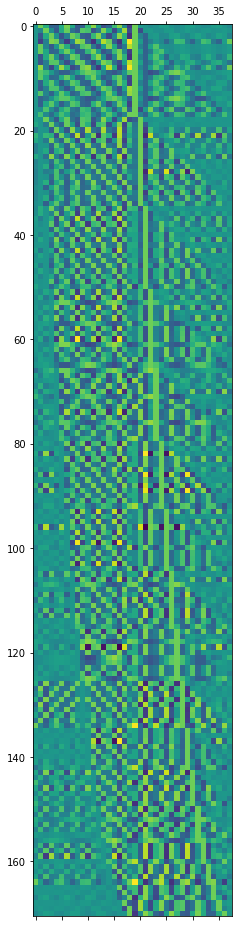

In [120]:
plt.matshow(array[:,2:45])


In [ ]:
# 448771 |0> SPAM
# 448772 |1> SPAM
# 448781 : 0 steps wait
# 448782 : 4 steps wait
# 448783 : 2 steps wait
# 448784 : 1 step  wait
# 448785 : 4 steps wait, no initial rotation
